# Importación de Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay)

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Carga del dataset y limpieza inicial

In [3]:
file_path = "/content/drive/MyDrive/Dataset.xlsx"
df = pd.read_excel(file_path, sheet_name='student_info')

# Convertir columnas numéricas
numerical_cols = ['math_score', 'reading_score', 'writing_score', 'attendance_rate', 'study_hours']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Corregir posibles errores de escala (usamos 1e2 para escalas más realistas)
df['attendance_rate'] = df['attendance_rate'] / 1e2
df['study_hours'] = df['study_hours'] / 1e2

# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Convertir variable objetivo a binaria
df['final_result'] = df['final_result'].map({'Pass': 1, 'Fail': 0})
df = df[df['final_result'].notnull()]

df.head()


,student_id,name,gender,age,grade_level,math_score,reading_score,writing_score,attendance_rate,parent_education,study_hours,internet_access,lunch_type,extra_activities,final_result
0,S1,Student_1,Other,17,10,74,61,90,9.466000e+13,Master's,4.120192e+13,Yes,Free or reduced,Yes,0
1,S2,Student_2,Male,17,12,99,70,91,9.317323e+13,Bachelor's,2.886505e+14,No,Free or reduced,No,1
2,S3,Student_3,Other,17,9,59,60,99,9.863110e+13,PhD,1.909926e+12,No,Free or reduced,No,0
3,S4,Student_4,Other,17,12,70,88,69,9.641962e+13,PhD,1.664740e+14,No,Standard,No,1
4,S5,Student_5,Male,15,9,85,77,94,9.133211e+13,PhD,2.330918e+14,Yes,Free or reduced,No,1


#  Análisis Exploratorio

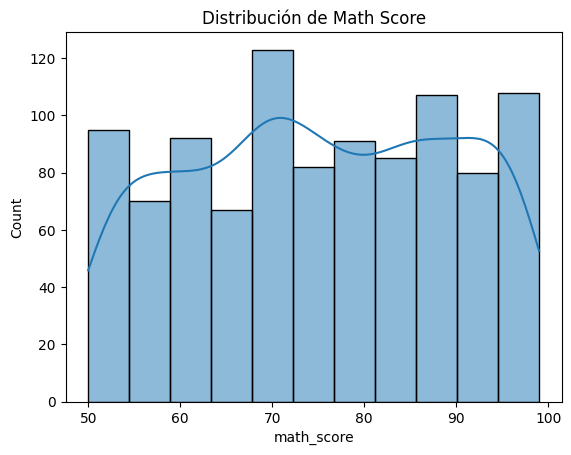

In [4]:
# Distribuciones
sns.histplot(df['math_score'], kde=True)
plt.title("Distribución de Math Score")
plt.show()



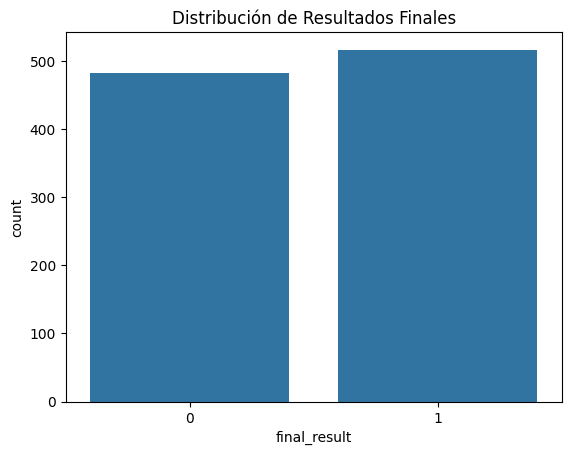

In [5]:
sns.countplot(data=df, x='final_result')
plt.title("Distribución de Resultados Finales")
plt.show()

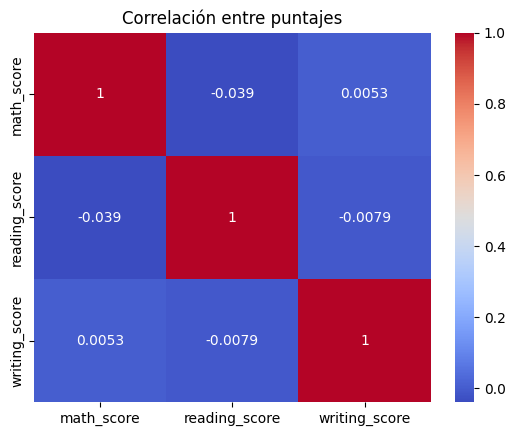

In [6]:
# Correlaciones
sns.heatmap(df[numerical_cols[:-2]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación entre puntajes")
plt.show()

# Balanceo de clases

In [8]:
# Verificar desbalance
print(df['final_result'].value_counts())

# Balanceo con sobre-muestreo
df_pass = df[df['final_result'] == 1]
df_fail = df[df['final_result'] == 0]

df_fail_upsampled = df_fail.sample(n=len(df_pass), replace=True, random_state=42)
df_balanced = pd.concat([df_pass, df_fail_upsampled])

print("Después del balanceo:", df_balanced['final_result'].value_counts())


final_result
1    517
0    483
Name: count, dtype: int64
Después del balanceo: final_result
1    517
0    517
Name: count, dtype: int64


# Dividimos los datos y escalamos

In [9]:

features = ['math_score', 'reading_score', 'writing_score', 'attendance_rate', 'study_hours']
X = df_balanced[features]
y = df_balanced['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Entrenamos al Modelo y hacemos la comparacion de modelos

In [10]:
# Modelos
log_model = LogisticRegression()
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Entrenar
log_model.fit(X_train_scaled, y_train)
tree_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_log = log_model.predict(X_test_scaled)
y_pred_tree = tree_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

# Accuracy
acc_log = accuracy_score(y_test, y_pred_log)
acc_tree = accuracy_score(y_test, y_pred_tree)
acc_rf = accuracy_score(y_test, y_pred_rf)


# Obtenemos los reportes y las visualizaciones

In [20]:
# Reportes
print("Logistic Regression:\n", classification_report(y_test, y_pred_log))
print("Decision Tree:\n", classification_report(y_test, y_pred_tree))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))



Logistic Regression:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50       105
           1       0.49      0.49      0.49       102

    accuracy                           0.49       207
   macro avg       0.49      0.49      0.49       207
weighted avg       0.49      0.49      0.49       207

Decision Tree:
               precision    recall  f1-score   support

           0       0.50      0.90      0.64       105
           1       0.42      0.08      0.13       102

    accuracy                           0.49       207
   macro avg       0.46      0.49      0.39       207
weighted avg       0.46      0.49      0.39       207

Random Forest:
               precision    recall  f1-score   support

           0       0.65      0.70      0.68       105
           1       0.67      0.62      0.64       102

    accuracy                           0.66       207
   macro avg       0.66      0.66      0.66       207
weighted avg       0

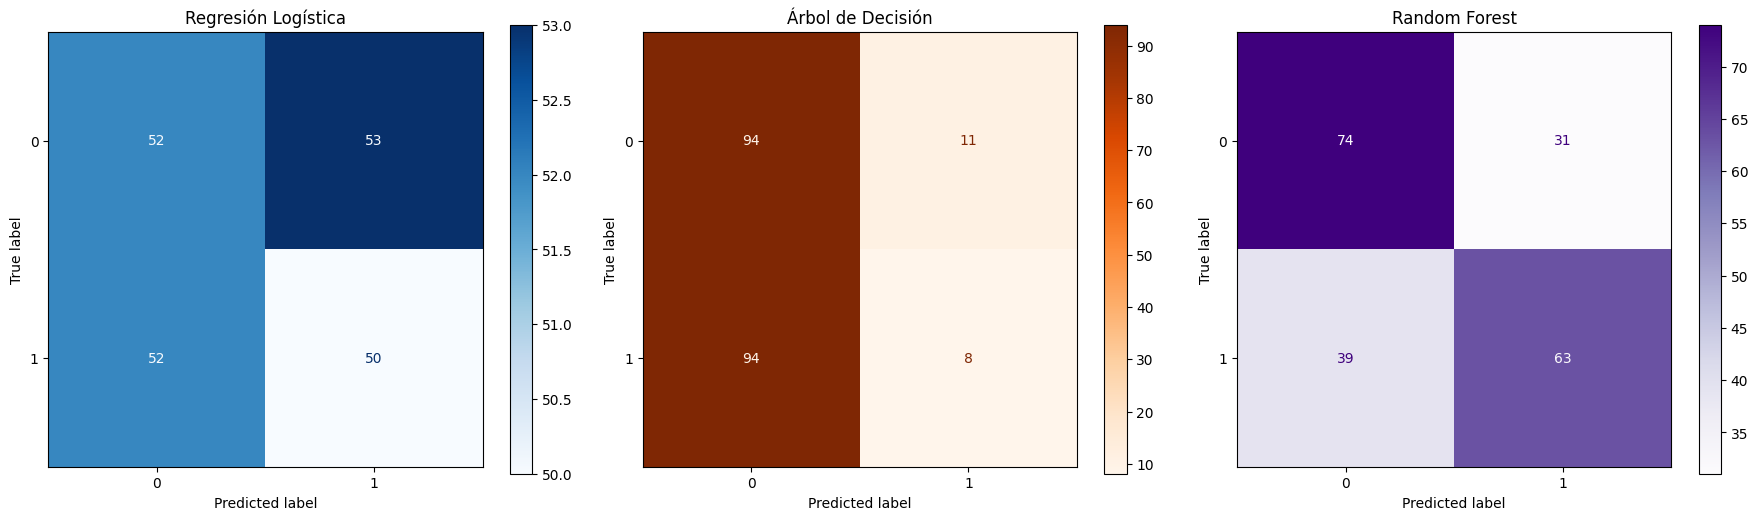

In [21]:
# Matrices de Confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axes[0], cmap='Blues')
axes[0].set_title("Regresión Logística")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree, ax=axes[1], cmap='Oranges')
axes[1].set_title("Árbol de Decisión")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[2], cmap='Purples')
axes[2].set_title("Random Forest")

plt.tight_layout()
plt.show()

# Hacemos una comparación de valores reales con predichos

<ipython-input-13-182248709>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Resultado', data=comparacion, palette='Set2')


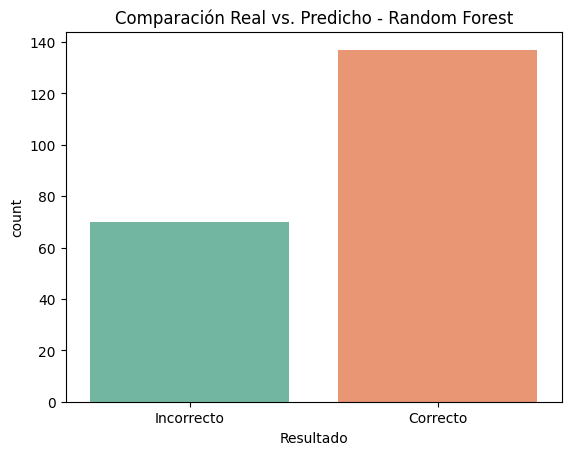

In [13]:
# Elijo  el modelo (ej: Random Forest)
y_pred = y_pred_rf

comparacion = pd.DataFrame({'Real': y_test.values, 'Predicho': y_pred})
comparacion['Resultado'] = np.where(comparacion['Real'] == comparacion['Predicho'], 'Correcto', 'Incorrecto')

sns.countplot(x='Resultado', data=comparacion, palette='Set2')
plt.title("Comparación Real vs. Predicho - Random Forest")
plt.show()


# ¿Cuáles son los perfiles de estudiantes con mayor riesgo de desaprobar según sus características académicas y sociales?

In [14]:
df_fail = df_balanced[df_balanced['final_result'] == 0]
print(df_fail[features].describe())




       math_score  reading_score  writing_score  attendance_rate   study_hours
count  517.000000     517.000000     517.000000     5.170000e+02  5.170000e+02
mean    74.075435      74.261122      74.696325     7.893817e+13  1.381350e+14
std     13.825186      14.759161      14.694520     2.780164e+13  1.334346e+14
min     50.000000      50.000000      50.000000     9.080599e+10  1.504441e+11
25%     64.000000      61.000000      62.000000     8.230292e+13  3.423587e+13
50%     72.000000      73.000000      74.000000     8.815496e+13  4.942403e+13
75%     86.000000      86.000000      88.000000     9.316320e+13  2.237850e+14
max     99.000000      99.000000      99.000000     9.985029e+13  4.763003e+14


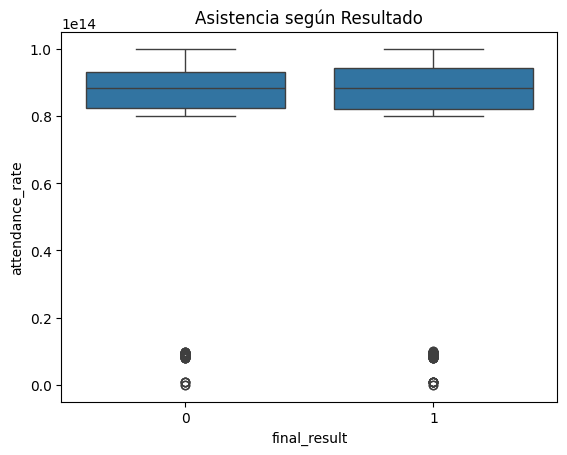

In [16]:
# Boxplots
sns.boxplot(x='final_result', y='attendance_rate', data=df_balanced)
plt.title("Asistencia según Resultado")
plt.show()



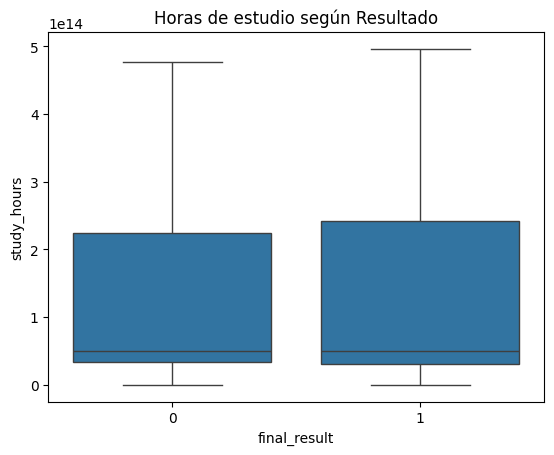

In [17]:
sns.boxplot(x='final_result', y='study_hours', data=df_balanced)
plt.title("Horas de estudio según Resultado")
plt.show()

# ¿Qué variables predicen mejor el rendimiento académico de un estudiante?

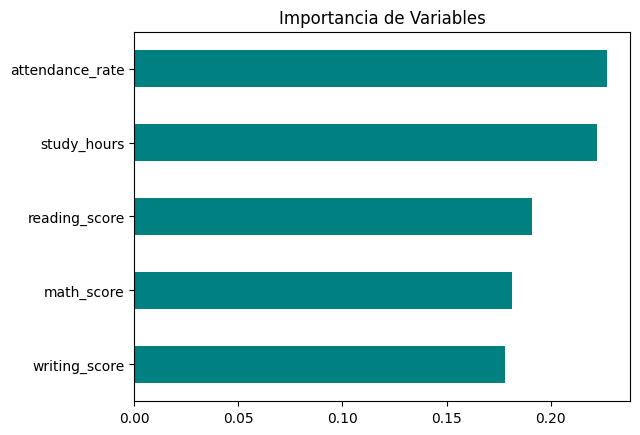

In [18]:
# Las variables que predicen mejor el rendimiento academico

importancia = pd.Series(rf_model.feature_importances_, index=features)
importancia.sort_values().plot(kind='barh', color='teal')
plt.title("Importancia de Variables")
plt.show()


# ¿Qué combinación de factores predice con mayor eficacia el fracaso escolar?

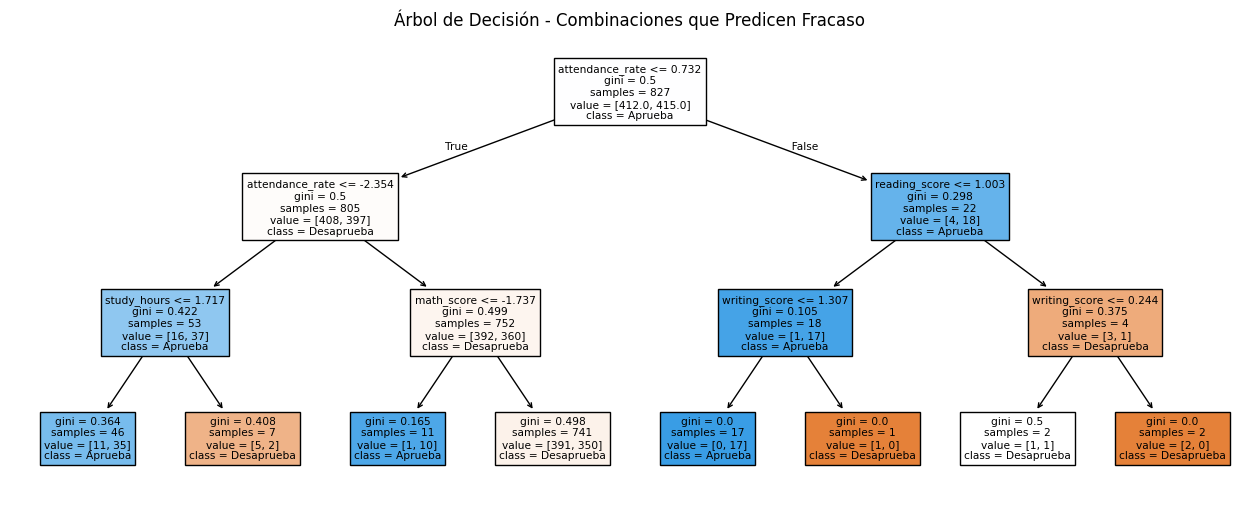

In [19]:
#Árbol de decisión para interpretar combinaciones de fracaso
plt.figure(figsize=(16, 6))
plot_tree(tree_model, feature_names=features, class_names=['Desaprueba', 'Aprueba'], filled=True)
plt.title("Árbol de Decisión - Combinaciones que Predicen Fracaso")
plt.show()
